<a href="https://colab.research.google.com/github/mdlakic/t-SNE_binning/blob/main/tSNE_bayes_HDB_openTSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter an explanation here.

In [3]:
#@markdown # Program settings
#@markdown - Type the directory name where binned contigs will be saved:
bins = "bins" #@param {type:"string"}
#@markdown - Perplexity is the minimum number of expected DNA fragments in the same group.
#@markdown - It has the biggest effect on the final outcome. Values in the 20-80 range are reasonable.
#@markdown - Keep in mind that contigs are chopped into pieces, so the fragment number is greater than contig number.
perplexity = 40 #@param {type:"integer"}
#@markdown - Theta angle for Barnes-Hut t-SNE approximation ( https://arxiv.org/abs/1301.3342 )
#@markdown - The range is [0 - 0.5] and values close to zero are more accurate but will result in very slow embedding.
#@markdown - Leave it at default value of -1 for the script to decide the theta angle based on data size.
theta_val = -1 #@param {type:"number"}
#@markdown - Number of threads to use. Free Google Colab will give you 2; increase to larger number if you are paying.
threads = 2 #@param {type:"integer"}
#@markdown - Dimensionality of t-SNE:
dims = 2 #@param [2,3] {type:"raw"}
#@markdown - Specify the shade of ellipses - high numbers make darker ellipses, while small are more transparet.
image_alpha = 0.3 #@param {type:"number"}
#@markdown - Type the plot name for final t-SNE clusters:
tsne_plot = "contigs_opentSNE_HDB_clusters.png" #@param {type:"string"}
#@markdown - What title do you want for the t-SNE plot?
plot_title = "t-SNE embedding" #@param {type:"string"}
#@markdown - Final CSV file with tSNE clusters:
tsne_clusters = "contigs_opentSNE_HDB_clusters.csv" #@param {type:"string"}
#@markdown - What type of initialization to use before running t-SNE?
initial_embedding = "spectral" #@param ["pca", "spectral"]
#@markdown - Use black background instead of white for the t-SNE plot?
black_bkg = False #@param {type:"boolean"}
#@markdown - Kmer size for nucleotide frequency calculation:
kmer_size = 4 #@param [4,5] {type:"raw"}
#@markdown - Cutoff size to retain contigs. Contigs smaller than this value are excluded from binning. This is also the overlap between contigs.
low_cutoff = "2k" #@param ["1k", "2k", "3k", "4k", "5k"]
#@markdown - Cutoff size for for chopping contigs:
high_cutoff = "10k" #@param ["10k", "20k"]
#@markdown - t-SNE metric:
tsne_metric = "cosine" #@param ["euclidean","cosine","manhattan","cityblock"]
#@markdown - Acceptable fraction of unbinned data points (0 means keep all):
noise_threshold = 0.2 #@param {type:"number"}
#@markdown - Number of Bayesian optimizations to find clustering parameters. It is usually enough to do 100, but for large dataset you may want to consider 200.
trials = 100 #@param [50,100,150,200] {type:"raw"}
#@markdown - Use Bayesian optimization to find clustering parameters? It is slower but more accurate.
hyperopt = True #@param {type:"boolean"}
#@markdown - Use FastICA to reduce dimensionality before t-SNE? Usually not necessary.
ica = False #@param {type:"boolean"}
#@markdown - Size of data points in t-SNE plot. Use smaller point size for large assemblies.
point_size = 5 #@param [1,2,5,10] {type:"raw"}
#@markdown - Type in a fixed random seed for reproducibility. Leave it at `-1` for a different seed each time.
rand_seed = -1 #@param {type:"integer"}
#@markdown - Do you want printed information along the way? 
verbose = True #@param {type:"boolean"}


In [4]:
from google.colab import files

uploaded = files.upload()
for input_file in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=input_file, length=len(uploaded[input_file])))

Saving Perpetual_Spouter_A.contigs_2k.fa to Perpetual_Spouter_A.contigs_2k.fa
User uploaded file "Perpetual_Spouter_A.contigs_2k.fa" with length 51130564 bytes


In [31]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c bioconda seqkit
!pip install checkm-genome
!pip install opentsne==0.7.1
!pip install hdbscan==0.8.29
!pip install seqtk
!pip install wget
!pip install Bio
import wget
wget.download('https://github.com/BinPro/CONCOCT/raw/develop/scripts/cut_up_fasta.py')
wget.download('https://github.com/BinPro/CONCOCT/raw/develop/scripts/extract_fasta_bins.py')
wget.download('https://github.com/BinPro/CONCOCT/raw/develop/scripts/merge_cutup_clustering.py')
# !python cut_up_fasta.py -h
import os
import shutil
import itertools
import argparse
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(style='white', color_codes=True)
import numpy as np
np.random.seed()
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker
import matplotlib.animation as animation
from openTSNE import TSNE
import hdbscan
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import linalg
import joblib
from sklearn.metrics import silhouette_score
from termcolor import colored
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import FastICA
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import csv

✨🍰✨ Everything looks OK!
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 44.8 MB/s

In [6]:
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('max_colwidth', 1000)

search_space = {
    'min_cluster_size': hp.quniform('x_min_cluster_size', 10, 75, 1),
    'min_samples': hp.quniform('x_min_samples', 5, 60, 1),
    'cluster_selection_epsilon': hp.uniform('x_cluster_selection_epsilon', 0, 0.5)
               }

trials = Trials()

In [9]:
jobs = threads
hdb_model = 'HDB_' + os.path.splitext(tsne_plot)[0] + '_model.joblib'
if (rand_seed == -1):
    rand_num = np.random.randint(1000000)
else:
    rand_num = rand_seed

if low_cutoff == '1k':
    lc_size = 1000
    lc_abbrev = '1K'
if low_cutoff == '2k':
    lc_size = 2000
    lc_abbrev = '2K'
if low_cutoff == '3k':
    lc_size = 3000
    lc_abbrev = '3K'
if low_cutoff == '4k':
    lc_size = 4000
    lc_abbrev = '4K'
if low_cutoff == '5k':
    lc_size = 5000
    lc_abbrev = '5K'
if high_cutoff == '10k':
    hc_size = 10000
    hc_abbrev = '10K'
if high_cutoff == '20k':
    hc_size = 20000
    hc_abbrev = '20K'
    
def hyperspace(search_space):

    global jobs
    global min_cluster_size_list
    global min_samples_list
    global epsilon_list
    global noise_list
    global silhouette_list
    global fraction_list
    global sscore_best
    global failed_score_best
    global noise_best
    global cluster_list
    global noise_threshold

    print('\n Current HDBSCAN parameters: min_cluster_size = %d  min_samples = %d  cluster_selection_epsilon = %.5f' % (search_space['min_cluster_size'], search_space['min_samples'], search_space['cluster_selection_epsilon']) )
    min_cluster_size_list.append(int(search_space['min_cluster_size']))
    min_samples_list.append(int(search_space['min_samples']))
    epsilon_list.append(search_space['cluster_selection_epsilon'])
    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=int(search_space['min_cluster_size']), min_samples=int(search_space['min_samples']), cluster_selection_epsilon=search_space['cluster_selection_epsilon'], core_dist_n_jobs=jobs, prediction_data=True)

    tmp = train
    tmp['clabels'] = hdbscanner.fit_predict(train[col_names].values)
    noise = tmp.loc[tmp.clabels == -1]
    noise_list.append(len(noise))
    cluster_list.append(len(np.unique(tmp.clabels))-1)
    fraction_list.append(len(noise)/float(total_points))
    if len(noise) < noise_best:
        noise_best = len(noise)
        noise_str = colored('%.3f %%' % (100*(len(noise)/float(total_points))), 'white', 'on_red')
    else:
        noise_str = str('%.3f %%' % (100*(len(noise)/float(total_points))))
    clean = tmp.loc[tmp.clabels != -1]
    clean.reset_index(drop=True, inplace=True)
    clean_data = clean.drop(['clabels'], axis=1).values
    sscore = silhouette_score(clean_data, clean['clabels'].values, metric='euclidean')
    if (noise_threshold>(len(noise)/float(total_points))):
        silhouette_list.append(sscore)
    else:
        silhouette_list.append(0.1)
    if (sscore > sscore_best) and (noise_threshold>(len(noise)/float(total_points))):
        sscore_best = sscore
        sscore_str = colored('%.5f' % sscore, 'white', 'on_blue')
    elif (sscore > sscore_best) and (sscore > failed_score_best) and (noise_threshold<(len(noise)/float(total_points))):
        failed_score_best = sscore
        sscore_str = colored('%.5f' % sscore, 'red', 'on_yellow')
    else:
        sscore_str = str('%.5f' % sscore)
    if verbose:
        print(' silhouette_score: %s  noise: %s  clusters: %d' % (sscore_str, noise_str, np.unique(clean['clabels'].values).shape[0]) )

    std_score = 0.01
    if (noise_threshold>(len(noise)/float(total_points))):
        val_score = -1.0 * sscore
    else:
        val_score = -0.1

    return {'loss': val_score, 'loss_variance': std_score, 'status': STATUS_OK }

In [10]:
class EllipsoidTool:
    """Some stuff for playing with ellipsoids"""
    def __init__(self):
        pass

    def getMinVolEllipse(self, P=None, tolerance=0.001):
        """ Find the minimum volume ellipsoid which holds all the points

        Based on work by Nima Moshtagh
        http://www.mathworks.com/matlabcentral/fileexchange/9542
        and also by looking at:
        http://cctbx.sourceforge.net/current/python/scitbx.math.minimum_covering_ellipsoid.html
        Which is based on the first reference anyway!

        Here, P is a numpy array of N dimensional points like this:
        P = [[x,y,z,...], <-- one point per line
             [x,y,z,...],
             [x,y,z,...]]

        Returns:
        (center, radii, rotation)

        """
        (N, d) = np.shape(P)
        d = float(d)

        # Q will be our working array
        Q = np.vstack([np.copy(P.T), np.ones(N)])
        QT = Q.T

        # initializations
        err = 1.0 + tolerance
        u = (1.0 / N) * np.ones(N)

        # Khachiyan Algorithm
        while err > tolerance:
            V = np.dot(Q, np.dot(np.diag(u), QT))
            M = np.diag(np.dot(QT, np.dot(
                linalg.inv(V), Q)))  # M the diagonal vector of an NxN matrix
            j = np.argmax(M)
            maximum = M[j]
            step_size = (maximum - d - 1.0) / ((d + 1.0) * (maximum - 1.0))
            new_u = (1.0 - step_size) * u
            new_u[j] += step_size
            err = np.linalg.norm(new_u - u)
            u = new_u

        # center of the ellipse
        center = np.dot(P.T, u)

        # the A matrix for the ellipse
        A = linalg.inv(
            np.dot(P.T, np.dot(np.diag(u), P)) -
            np.array([[a * b for b in center] for a in center])) / d

        # Get the values we'd like to return
        U, s, rotation = linalg.svd(A)
        radii = 1.0 / np.sqrt(s)

        return (center, radii, rotation)

    def getEllipsoidVolume(self, radii):
        """Calculate the volume of the blob"""
        return 4. / 3. * np.pi * radii[0] * radii[1] * radii[2]

    def plotEllipsoid(self,
                      center,
                      radii,
                      rotation,
                      ax=None,
                      plotAxes=False,
                      cageColor='b',
                      cageAlpha=0.2):
        """Plot an ellipsoid"""
        make_ax = ax == None
        if make_ax:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_aspect('equal')

        u = np.linspace(0.0, 2.0 * np.pi, 100)
        v = np.linspace(0.0, np.pi, 100)

        # cartesian coordinates that correspond to the spherical angles:
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
        # rotate accordingly
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i, j], y[i, j], z[i, j]
                 ] = np.dot([x[i, j], y[i, j], z[i, j]], rotation) + center

        if plotAxes:
            # make some purdy axes
            axes = np.array([[radii[0], 0.0, 0.0], [0.0, radii[1], 0.0],
                             [0.0, 0.0, radii[2]]])
            # rotate accordingly
            for i in range(len(axes)):
                axes[i] = np.dot(axes[i], rotation)

            # plot axes
            for p in axes:
                X3 = np.linspace(-p[0], p[0], 100) + center[0]
                Y3 = np.linspace(-p[1], p[1], 100) + center[1]
                Z3 = np.linspace(-p[2], p[2], 100) + center[2]
                ax.plot(X3, Y3, Z3, color=cageColor)

        # plot ellipsoid
        # ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cageColor, alpha=cageAlpha)
        ax.plot_wireframe(x,
                          y,
                          z,
                          rstride=2,
                          cstride=2,
                          color=cageColor,
                          alpha=cageAlpha)

        if make_ax:
            plt.show()
            plt.close(fig)
            del fig

In [11]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(),
                                 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' %
              (thour, tmin, round(tsec, 2)))

In [12]:
def draw_tsne(data=None,
              n_neighbors=15,
              min_dist=0.1,
              n_components=2,
              metric='euclidean',
              title=''):
    print('n_neighbors=%d   min_dist=%.2f' % (n_neighbors, min_dist))
    fit = tsne.tSNE(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components,
                    metric=metric)
    start_time = timer(None)
    u = fit.fit_transform(data)
    timer(start_time)

    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=20)
    labels = hdbscanner.fit_predict(u)
    print('Clusters %d' % np.max(labels))

    fig = plt.figure(figsize=(7, 6))
    if n_components == 1:
        ax = fig.add_subplot(111)
        cb = ax.scatter(u[:, 0], range(len(u)), cmap=cm, c=labels, s=2)
        plt.colorbar(cb)
    if n_components == 2:
        ax = fig.add_subplot(111)
        cb = ax.scatter(u[:, 0], u[:, 1], cmap=cm, c=labels, s=2)
        plt.colorbar(cb)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        cb = ax.scatter(u[:, 0], u[:, 1], u[:, 2], cmap=cm, c=labels, s=2)
        plt.colorbar(cb)
    plt.title(title, fontsize=16)
    plt.show()


def plot_results(X, Y_, nclus, index, title):

    unique_labels = np.arange(nclus).astype(np.int)
    splot = plt.subplot(1, 2, index)
    splot.tick_params(axis='both', which='major', labelsize=12)
    splot.tick_params(axis='both', which='minor', labelsize=12)
    for i, (zz, color) in enumerate(zip(unique_labels, color_iter_one)):
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == zz, 0],
                    X[Y_ == zz, 1],
                    marker='.',
                    s=point_size,
                    c=color)

    if np.min(Y_) == -1:
        plt.scatter(X[Y_ == -1, 0],
                    X[Y_ == -1, 1],
                    marker='.',
                    s=point_size,
                    c='k')

    ell = EllipseModel()
    for zz in unique_labels:
        dp = X[Y_ == zz]
        in_out = EllipticEnvelope(contamination=0.05).fit_predict(dp)
        a_points = dp[in_out == 1]
        ell_status = ell.estimate(a_points)
        if ell_status:
            xc, yc, a, b, theta = ell.params
            ell_patch = Ellipse((xc, yc),
                                3 * a,
                                3 * b,
                                theta * 180 / np.pi,
                                edgecolor='red',
                                facecolor='none')
            splot.add_patch(ell_patch)
            plt.text(xc, yc, str(zz), fontsize=11)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title, fontsize=15)

def ani_update(embedding, ax, pathcol):
    # Update point positions
    pathcol.set_offsets(embedding)

    # Adjust x/y limits so all the points are visible
    ax.set_xlim(np.min(embedding[:, 0])-5, np.max(embedding[:, 0])+5)
    ax.set_ylim(np.min(embedding[:, 1])-5, np.max(embedding[:, 1])+5)

    return [pathcol]


 !! The directory you chose already exists, and its contents will be cleared !!
total 165028
drwxr-xr-x 1 root root     4096 May  6 06:18  .
-rw-r--r-- 1 root root     2283 May  6 06:18 'merge_cutup_clustering (1).py'
-rw-r--r-- 1 root root     1522 May  6 06:18 'extract_fasta_bins (1).py'
-rw-r--r-- 1 root root     2736 May  6 06:18 'cut_up_fasta (1).py'
-rw-r--r-- 1 root root      681 May  6 06:17  contigs_10K_2K.4mer_noindex.csv
-rw-r--r-- 1 root root       12 May  6 06:17  contigs_10K_2K.4mer_index.csv
-rw-r--r-- 1 root root      692 May  6 06:17  contigs_10K_2K.4mer.csv
-rw-r--r-- 1 root root      692 May  6 06:17  contigs_10K_2K.4mer.tab
-rw-r--r-- 1 root root 17846659 May  6 06:17  contigs_4mer.tab
-rw-r--r-- 1 root root        0 May  6 06:16  contigs_10K_2K.fasta
-rw-r--r-- 1 root root        0 May  6 06:16  contigs_10K.fasta
-rw-r--r-- 1 root root       96 May  6 06:16  script.sh
drwxr-xr-x 2 root root     4096 May  6 06:03  .ipynb_checkpoints
-rw-r--r-- 1 root root     2283 

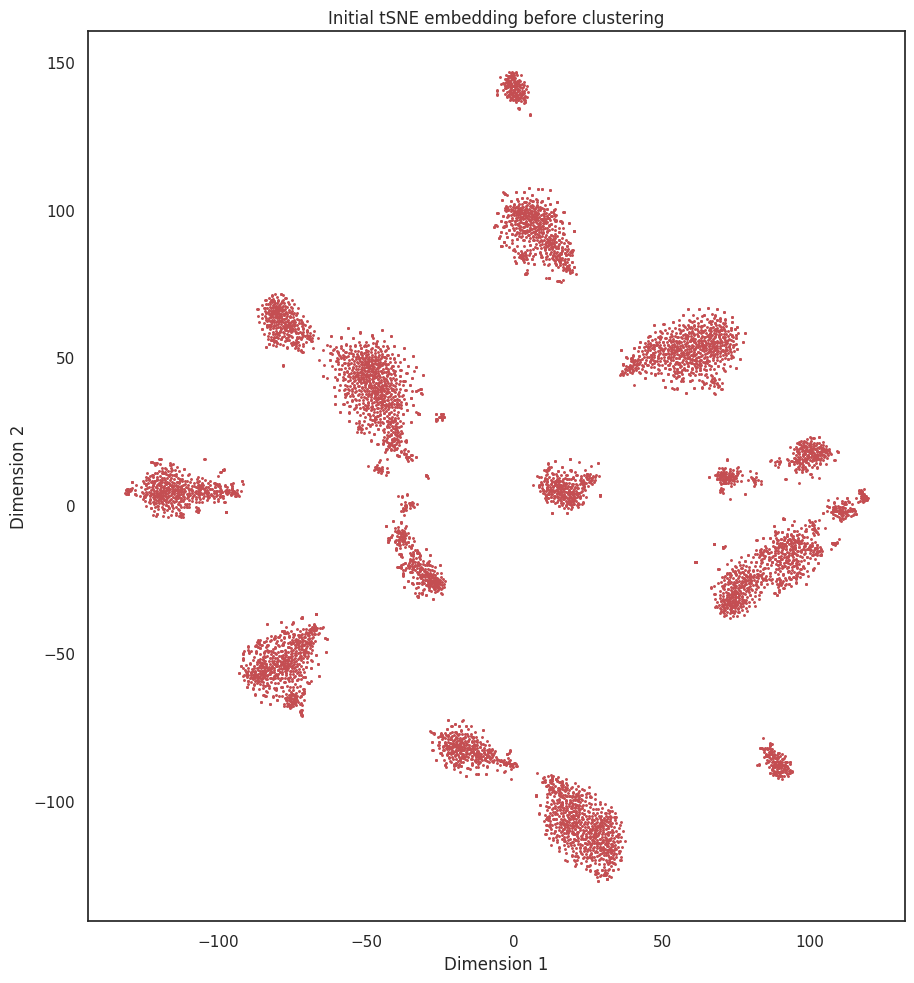


 Starting HDBSCAN clustering. This may take a while ...


 Current HDBSCAN parameters: min_cluster_size = 26  min_samples = 26  cluster_selection_epsilon = 0.06005
 silhouette_score: 0.66838  noise: 0.066 %  clusters: 14

 Current HDBSCAN parameters: min_cluster_size = 70  min_samples = 51  cluster_selection_epsilon = 0.21108
 silhouette_score: 0.69355  noise: 1.390 %  clusters: 15

 Current HDBSCAN parameters: min_cluster_size = 63  min_samples = 16  cluster_selection_epsilon = 0.12710
 silhouette_score: 0.67840  noise: 0.354 %  clusters: 15

 Current HDBSCAN parameters: min_cluster_size = 56  min_samples = 24  cluster_selection_epsilon = 0.39719
 silhouette_score: 0.67722  noise: 0.171 %  clusters: 15

 Current HDBSCAN parameters: min_cluster_size = 41  min_samples = 52  cluster_selection_epsilon = 0.36775
 silhouette_score: 0.69319  noise: 1.430 %  clusters: 15

 Current HDBSCAN parameters: min_cluster_size = 34  min_samples = 31  cluster_selection_epsilon = 0.01174
 silhouette_sco

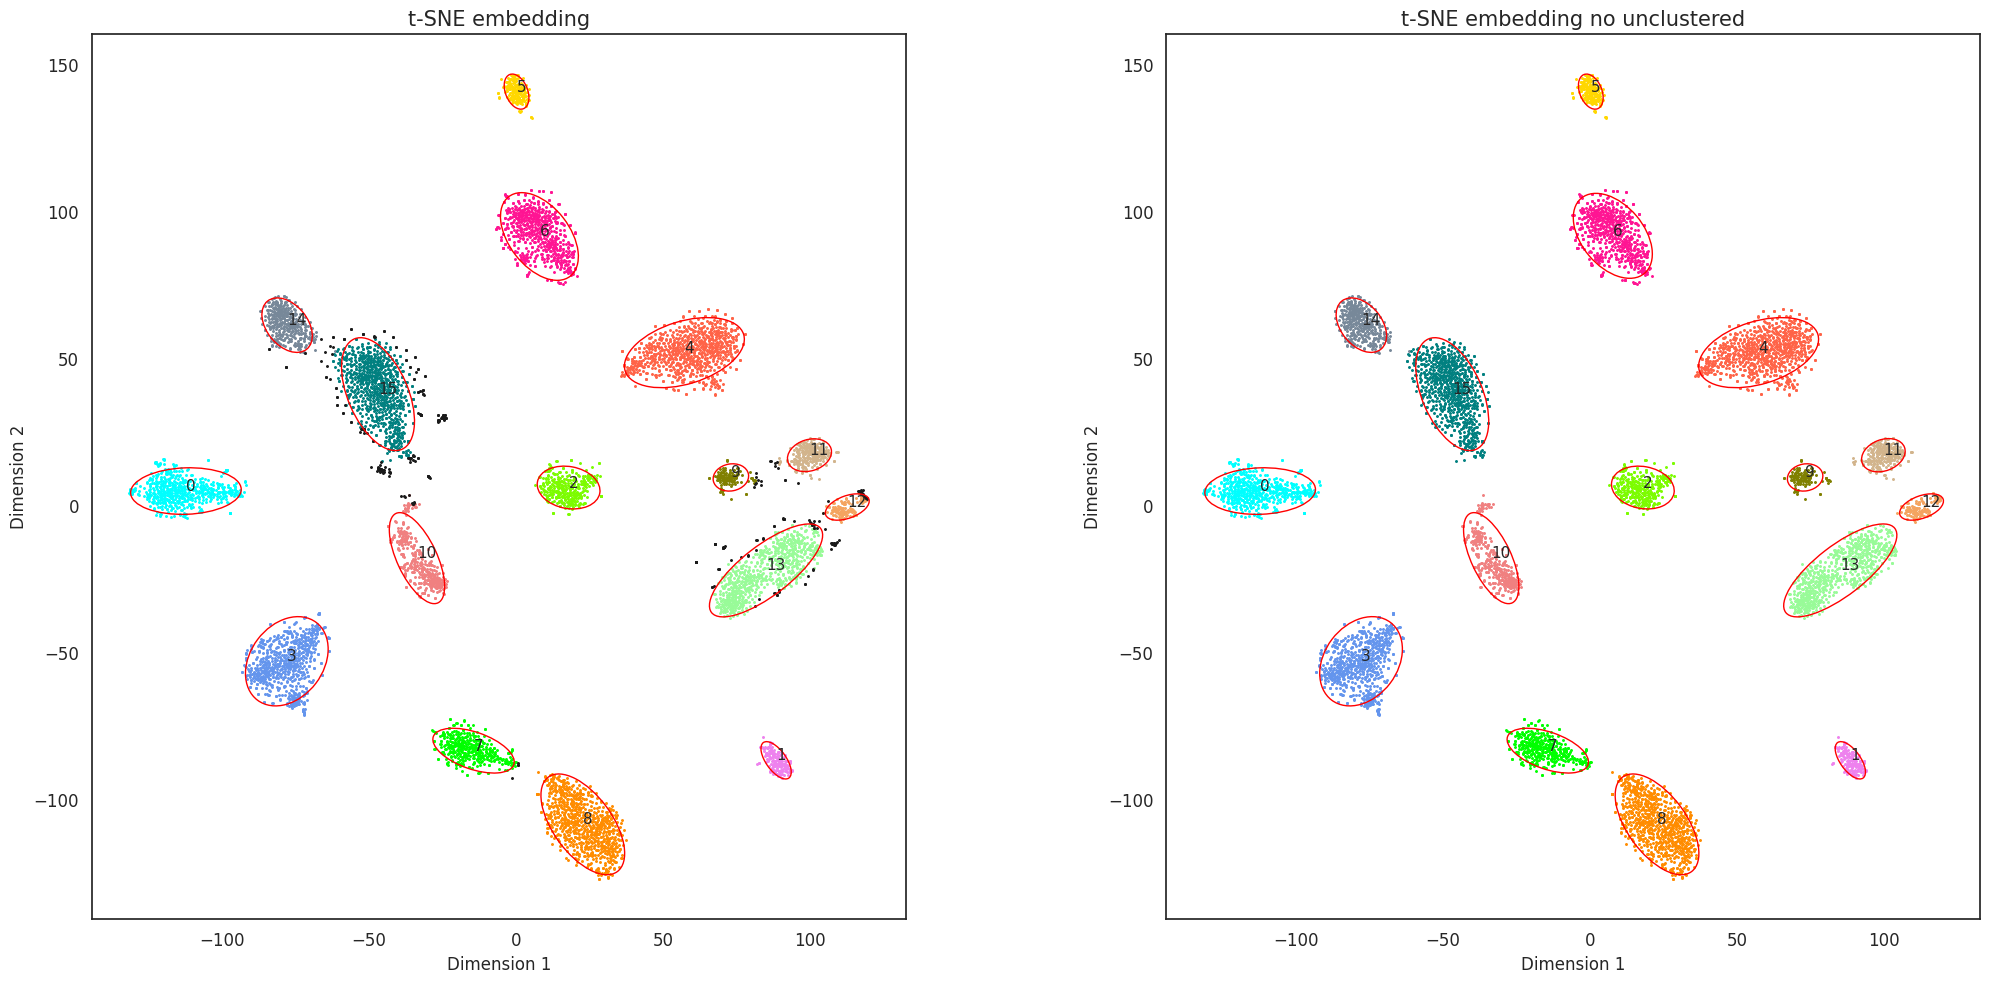


 tSNE plot saved as contigs_opentSNE_HDB_clusters.png


ValueError: ignored

In [32]:
if os.access(input_file, os.R_OK):

    if not os.path.exists(bins):
        os.makedirs(bins)  # to create a directory recursively
    else:
        print(
            '\n !! The directory you chose already exists, and its contents will be cleared !!'
        )
        for root, dirs, files in os.walk(bins):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                shutil.rmtree(os.path.join(root, name))

    !ls -alt
    if verbose:
        print('\n Splitting DNA sequences into %s pieces ...' % hc_abbrev)
#    sh = 'python cut_up_fasta.py -c %d -o %d -m %s > contigs_%s.fasta' % (hc_size, lc_size, input_file, hc_abbrev)
#    with open('script.sh', 'w') as file:
#        file.write(sh)
#    !bash script.sh
    os.system('python cut_up_fasta.py -c %d -o %d -m %s > contigs_%s.fasta' %
              (hc_size, lc_size, input_file, hc_abbrev))
    if verbose:
        print('\n Removing contigs smaller than %s ...' % lc_abbrev)
#    print('seqkit seq -u -m %d contigs_%s.fasta > contigs_%s_%s.fasta' %
#              (lc_size, hc_abbrev, hc_abbrev, lc_abbrev))
    os.system('seqkit seq -u -m %d contigs_%s.fasta > contigs_%s_%s.fasta' %
              (lc_size, hc_abbrev, hc_abbrev, lc_abbrev))
    if verbose:
        print('\n Calculating %d-mer frequencies ...' % kmer_size)
#    print(
#        'checkm tetra -t 6 contigs_%s_%s.fasta contigs_%s_%s.%dmer.tab > /dev/null'
#        % (hc_abbrev, lc_abbrev, hc_abbrev, lc_abbrev, kmer_size))
#    !checkm tetra -t 6 Perpetual_Spouter_A.contigs_2k.fa contigs_4mer.tab
    os.system(
        'checkm tetra -t 6 contigs_%s_%s.fasta contigs_%s_%s.%dmer.tab'
        % (hc_abbrev, lc_abbrev, hc_abbrev, lc_abbrev, kmer_size))
    os.system('cp contigs_%s_%s.%dmer.tab contigs_%s_%s.%dmer.csv' %
              (hc_abbrev, lc_abbrev, kmer_size, hc_abbrev, lc_abbrev, kmer_size))
    os.system('perl -pi -e "s/\t/\,/g" contigs_%s_%s.%dmer.csv' %
              (hc_abbrev, lc_abbrev, kmer_size))
    os.system(
        'awk -F , "{print \$1}" contigs_%s_%s.%dmer.csv > contigs_%s_%s.%dmer_index.csv'
        % (hc_abbrev, lc_abbrev, kmer_size, hc_abbrev, lc_abbrev, kmer_size))
#    !ls -alt
    reader_ = csv.reader(open( 'contigs_%s_%s.%dmer.csv' % (hc_abbrev, lc_abbrev, kmer_size)))
    writer_ = csv.writer(open( 'contigs_%s_%s.%dmer_noindex.csv' % (hc_abbrev, lc_abbrev, kmer_size), 'w' ))
    for line in reader_:
        # deal with empty line
        if not line:
            break
        del line[0]
        writer_.writerow(line)
#    os.system(
#        'delete_cols.py contigs_%s_%s.%dmer.csv contigs_%s_%s.%dmer_noindex.csv 0'
#        % (hc_abbrev, lc_abbrev, kmer_size, hc_abbrev, lc_abbrev, kmer_size))

    train_data = pd.read_csv('contigs_%s_%s.%dmer_noindex.csv' %
                             (hc_abbrev, lc_abbrev, kmer_size))
    train_data = train_data.values
    if (theta_val == -1.0):
        if train_data.shape[0] <= 10000:
            theta_val = 0.1
            early_exag = 1000
            iters = 3000
            psize = 2
        if (train_data.shape[0] > 10000) and (train_data.shape[0] <= 20000):
            theta_val = 0.2
            early_exag = 1500
            iters = 4000
            psize = 1
        if train_data.shape[0] > 20000:
            theta_val = 0.5
            early_exag = 2000
            iters = 5000
            psize = 1
    else:
        if train_data.shape[0] <= 10000:
            theta_val = theta_val
            early_exag = 1000
            iters = 3000
            psize = 2
        if (train_data.shape[0] > 10000) and (train_data.shape[0] <= 20000):
            theta_val = theta_val
            early_exag = 1500
            iters = 4000
            psize = 1
        if train_data.shape[0] > 20000:
            theta_val = theta_val
            early_exag = 2000
            iters = 5000
            psize = 1

    if dims == 2:
        embeddings = []
        if ica:
            ICA = FastICA(n_components=8, whiten=False, max_iter=20000, tol=0.0001)
            train_data_ICA = ICA.fit_transform(train_data)
        tsne = TSNE(perplexity=perplexity,
                    metric=tsne_metric,
                    n_jobs=jobs,
                    learning_rate='auto',
                    negative_gradient_method='bh',
                    theta=theta_val,
                    initialization=initial_embedding,
                    early_exaggeration_iter=early_exag,
                    early_exaggeration=18.0,
                    n_iter=iters,
                    # The embedding will be appended to the list we defined above, make sure we copy the
                    # embedding, otherwise the same object reference will be stored for every iteration
                    callbacks=lambda it, err, emb: embeddings.append(np.array(emb)),
                    # This should be done on every iteration
                    callbacks_every_iters=10,
                    verbose=verbose)
        start_time = timer(None)
        if ica:
            train = tsne.fit(train_data_ICA)
        else:
            train = tsne.fit(train_data)

        embeddings = embeddings[(int(early_exag/10)-2):]
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        plt.tight_layout()
        plt.gca().set_aspect('equal', adjustable='box')
        ax.set_xticks([]), ax.set_yticks([])
        pathcol = ax.scatter(embeddings[0][:, 0], embeddings[0][:, 1], c='r', s=psize, rasterized=True)
        anim = animation.FuncAnimation(fig, ani_update, fargs=(ax, pathcol), interval=100, frames=embeddings, blit=True)
        ani_name = tsne_plot.rsplit('.', 1)[0] + '.gif'
        mp4_name = tsne_plot.rsplit('.', 1)[0] + '.mp4'
        anim.save(ani_name, dpi=100, writer=animation.PillowWriter(fps=15))
        anim.save(mp4_name, dpi=100, fps=15)
        plt.close()

        total_points = train.shape[0]
        train = pd.DataFrame(train)
        timer(start_time)
    if dims == 3:
        os.system(
            'TSNEGenerator -i contigs_%s_%s.%dmer_noindex.csv -o data.dat -d 3 -p 20 -r %d -m 6000 > /dev/null'
            % (hc_abbrev, lc_abbrev, kmer_size, rand_num))
        print('\n Starting tSNE calculation. This may take a while ...')
        start_time = timer(None)
        os.system('bh_tsne_exag')
        timer(start_time)
        os.system('TSNEReader -i result.dat -o tmp.csv > /dev/null')
        train = pd.read_csv('tmp.csv', header=None)
        total_points = train.shape[0]
    if dims == 2:
        train.columns = ['tSNE_X', 'tSNE_Y']
    else:
        train.columns = ['tSNE_X', 'tSNE_Y', 'tSNE_Z']
    train.to_csv('contigs_hdbscan_%s_%s_%dD_%dmer_opentSNE.csv' %
                 (hc_abbrev, lc_abbrev, dims, kmer_size),
                 index=False)

    col_names = train.columns.values
    col_names_X = train.columns[0]
    col_names_Y = train.columns[1]
    if dims == 3:
        col_names_Z = train.columns[2]

    if dims == 2:
        plt.figure(figsize=(10, 10))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.scatter(train[col_names_X],
                    train[col_names_Y],
                    marker='.',
                    s=point_size,
                    color='r')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.title('Initial tSNE embedding before clustering')
        plt.tight_layout()
        plt.savefig('scatter_' + tsne_plot, dpi=300)
        plt.show()
        plt.close()

    if dims == 3:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_aspect('equal')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        ax.scatter(train[col_names_X],
                   train[col_names_Y],
                   train[col_names_Z],
                   marker='.',
                   s=point_size,
                   c='r')

        plt.title('Initial tSNE embedding before clustering')
        # plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig('scatter_' + tsne_plot, dpi=300)
        plt.show()
        plt.close()

    # Fit a Dirichlet process Gaussian mixture using given number of components
    print(
        '\n Starting HDBSCAN clustering. This may take a while ...\n')
    start_time = timer(None)

    min_cluster_size_list = []
    min_samples_list = []
    epsilon_list = []
    noise_list = []
    silhouette_list = []
    fraction_list = []
    sscore_best = -1
    failed_score_best = -1
    noise_best = total_points
    cluster_list = []
    noise_threshold = noise_threshold
    if not hyperopt:
        for kk in np.arange(10,41,2):
            for jj in np.arange(10,21):
                print(' min_cluster_size: %d   min_samples: %d' % (kk, jj) )
                min_cluster_size_list.append(int(kk))
                min_samples_list.append(int(jj))
                epsilon_list.append(0.)
                hdbscanner = hdbscan.HDBSCAN(min_cluster_size=int(kk), min_samples=int(jj), core_dist_n_jobs=jobs, prediction_data=True)
                # hdbscanner = hdbscan.HDBSCAN(min_cluster_size=kk, core_dist_n_jobs=jobs, prediction_data=True)
                tmp = train
                tmp['clabels'] = hdbscanner.fit_predict(train[col_names].values)
                noise = tmp.loc[tmp.clabels == -1]
                noise_list.append(len(noise))
                cluster_list.append(len(np.unique(tmp.clabels))-1)
                fraction_list.append(len(noise)/float(total_points))
                if len(noise) < noise_best:
                    noise_best = len(noise)
                    noise_str = colored('%.3f %%' % (100*(len(noise)/float(total_points))), 'white', 'on_red')
                else:
                    noise_str = str('%.3f %%' % (100*(len(noise)/float(total_points))))
                clean = tmp.loc[tmp.clabels != -1]
                clean.reset_index(drop=True, inplace=True)
                clean_data = clean.drop(['clabels'], axis=1).values
                sscore = silhouette_score(clean_data, clean['clabels'].values, metric='euclidean')
                silhouette_list.append(sscore)
                if sscore > sscore_best:
                    sscore_best = sscore
                    sscore_str = colored('%.5f' % sscore, 'white', 'on_blue')
                else:
                    sscore_str = str('%.5f' % sscore)
                if verbose:
                    print(' silhouette_score: %s  noise: %s  clusters: %d' % (sscore_str, noise_str, np.unique(clean['clabels'].values).shape[0]) )

    if hyperopt:
        best = fmin(
                    fn=hyperspace,  # "Loss" function to minimize
                    space=search_space,  # Hyperparameter space
#                    algo=anneal.suggest,  # Simulated annealing
                    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
                    trials=trials,
                    max_evals=trials,
                   )
        print('-'*70)
        print('Best HDBSCAN parameters:')
        print(str(best))

    timer(start_time)

    df = pd.DataFrame(min_cluster_size_list, columns=['min_cluster_size'])
    df['min_samples'] = min_samples_list
    df['epsilon'] = epsilon_list
    df['clusters'] = cluster_list
#    df['noise'] = noise_list
    df['noise'] = fraction_list
    df['noise'] = 100*df['noise'].values
    df['silhouette_score'] = silhouette_list
    df.sort_values('silhouette_score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    arr = df.values
    print(df)

    nclus = arr[0][3]
    if not hyperopt:
        hdbscanner = hdbscan.HDBSCAN(min_cluster_size=int(arr[0][0]), min_samples=int(arr[0][1]), core_dist_n_jobs=jobs, prediction_data=True)
    if hyperopt:
        hdbscanner = hdbscan.HDBSCAN(min_cluster_size=int(arr[0][0]), min_samples=int(arr[0][1]), cluster_selection_epsilon=float(arr[0][2]), core_dist_n_jobs=jobs, prediction_data=True)
    clabels = hdbscanner.fit_predict(train[col_names].values)
    joblib.dump(hdbscanner, hdb_model)

    clusters = pd.DataFrame(clabels.astype(np.int))
    train['cluster_labels'] = clabels
    train_new = train.loc[train.cluster_labels != -1]
    train_new.reset_index(drop=True, inplace=True)

    if dims == 2:
        plt.figure(figsize=(22, 10))
        if black_bkg:
            plt.style.use('dark_background')
        color_iter = itertools.cycle([
            'orchid', 'cyan', 'violet', 'lawngreen', 'cornflowerblue', 'tomato',
            'gold', 'deeppink', 'lime', 'darkorange', 'olive', 'lightcoral',
            'tan', 'sandybrown', 'palegreen', 'lightslategrey',
            'teal', 'red', 'dodgerblue', 'darkslategrey', 'mediumslateblue',
            'orangered', 'springgreen', 'mediumaquamarine', 'darkgrey', 'firebrick',
            'salmon', 'darkkhaki', 'yellowgreen', 'forestgreen', 'cadetblue',
            'plum', 'seagreen', 'royalblue', 'goldenrod', 'slateblue', 'fuchsia',
            'khaki', 'chocolate', 'hotpink', 'moccasin', 'crimson', 'peachpuff'
        ])
        color_iter_one = itertools.islice(color_iter, 1, None)
        plot_results(train[col_names].values, clabels, nclus, 1, plot_title)
        color_iter = itertools.cycle([
            'orchid', 'cyan', 'violet', 'lawngreen', 'cornflowerblue', 'tomato',
            'gold', 'deeppink', 'lime', 'darkorange', 'olive', 'lightcoral',
            'tan', 'sandybrown', 'palegreen', 'lightslategrey',
            'teal', 'red', 'dodgerblue', 'darkslategrey', 'mediumslateblue',
            'orangered', 'springgreen', 'mediumaquamarine', 'darkgrey', 'firebrick',
            'salmon', 'darkkhaki', 'yellowgreen', 'forestgreen', 'cadetblue',
            'plum', 'seagreen', 'royalblue', 'goldenrod', 'slateblue', 'fuchsia',
            'khaki', 'chocolate', 'hotpink', 'moccasin', 'crimson', 'peachpuff'
        ])
        color_iter_one = itertools.islice(color_iter, 1, None)
        plot_results(train_new[col_names].values, train_new['cluster_labels'].values, nclus, 2, plot_title + ' no unclustered')
        plt.tight_layout()
        plt.savefig(tsne_plot, dpi=300)
        plt.show()
        plt.close()

    if dims == 3:
        ET = EllipsoidTool()
        fig = plt.figure(figsize=(10, 8))
        if black_bkg:
            plt.style.use('dark_background')
        color_iter = itertools.cycle([
            'orchid', 'cyan', 'violet', 'lawngreen', 'cornflowerblue', 'tomato',
            'gold', 'deeppink', 'lime', 'darkorange', 'olive', 'lightcoral',
            'tan', 'sandybrown', 'palegreen', 'lightslategrey',
            'teal', 'red', 'dodgerblue', 'darkslategrey', 'mediumslateblue',
            'orangered', 'springgreen', 'mediumaquamarine', 'darkgrey', 'firebrick',
            'salmon', 'darkkhaki', 'yellowgreen', 'forestgreen', 'cadetblue',
            'plum', 'seagreen', 'royalblue', 'goldenrod', 'slateblue', 'fuchsia',
            'khaki', 'chocolate', 'hotpink', 'moccasin', 'crimson', 'peachpuff'
        ])
        color_iter_one = itertools.islice(color_iter, 1, None)

        ax = fig.add_subplot(111, projection='3d')
        ax.set_aspect('equal')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')

        unique_clusters = np.arange(nclus).astype(np.int)
        for i, (zz, color) in enumerate(zip(unique_clusters, color_iter_one)):
            ax.scatter(train.loc[train.cluster_labels == zz, col_names_X],
                       train.loc[train.cluster_labels == zz, col_names_Y],
                       train.loc[train.cluster_labels == zz, col_names_Z],
                       marker='.',
                       s=point_size,
                       c=color)

            dp = train.loc[train.cluster_labels == zz]
            a_points = dp[col_names].values
            # find the ellipsoid
            (center, radii, rotation) = ET.getMinVolEllipse(a_points, .001)
            # plot the ellipsoid
            ET.plotEllipsoid(center,
                             radii,
                             rotation,
                             ax=ax,
                             plotAxes=False,
                             cageColor=color,
                             cageAlpha=0.1)
            xc, yc, zc = center
            ax.text(xc, yc, zc, str(zz), 'y', fontsize=12)

        plt.title(plot_title, fontsize='16')
        plt.tight_layout()

        plt.savefig(tsne_plot, dpi=300)
        plt.show()
        plt.close()

    if verbose:
        print('\n tSNE plot saved as %s' % tsne_plot)

    train_index = pd.read_csv('contigs_%s_%s.%dmer_index.csv' %
                              (hc_abbrev, lc_abbrev, kmer_size))
    train_index['cluster_labels'] = clabels.astype(np.int)
    train_index.columns = ['contig_id', 'cluster_id']
    train_index.to_csv('%dD_' % dims + tsne_clusters, index=False)
    if verbose:
        print('\n Extracting clusters from %s\n' %
              ('%dD_' % dims + tsne_clusters))
    os.system('python merge_cutup_clustering.py %s > merged_%s' %
              (('%dD_' % dims + tsne_clusters),
               ('%dD_' % dims + tsne_clusters)))
    os.system('python extract_fasta_bins.py %s merged_%s --output_path %s' %
              (input_file,
               ('%dD_' % dims + tsne_clusters), bins))
    if os.path.exists('%s/group_-1.fa' % bins):
        os.system('mv -- %s/group_-1.fa %s/unclustered.fasta' % (bins, bins))

# remove tmp files
    if os.access('data.dat', os.R_OK):
        os.system('rm data.dat')
    if os.access('result.dat', os.R_OK):
        os.system('rm result.dat')
    if os.access('tmp.csv', os.R_OK):
        os.system('rm tmp.csv')
    if os.access('contigs_%s.fasta' % hc_abbrev, os.R_OK):
        os.system('rm contigs_%s.fasta' % hc_abbrev)
    if os.access('contigs_%s_%s.fasta' % (hc_abbrev, lc_abbrev), os.R_OK):
        os.system('rm contigs_%s_%s.fasta' % (hc_abbrev, lc_abbrev))
    if os.access(
            'contigs_%s_%s.%dmer.tab' % (hc_abbrev, lc_abbrev, kmer_size),
            os.R_OK):
        os.system('rm contigs_%s_%s.%dmer.tab' %
                  (hc_abbrev, lc_abbrev, kmer_size))
    if os.access(
            'contigs_%s_%s.%dmer.csv' % (hc_abbrev, lc_abbrev, kmer_size),
            os.R_OK):
        os.system('rm contigs_%s_%s.%dmer.csv' %
                  (hc_abbrev, lc_abbrev, kmer_size))
    if os.access(
            'contigs_%s_%s.%dmer_index.csv' %
        (hc_abbrev, lc_abbrev, kmer_size), os.R_OK):
        os.system('rm contigs_%s_%s.%dmer_index.csv' %
                  (hc_abbrev, lc_abbrev, kmer_size))
    if os.access(
            'contigs_%s_%s.%dmer_noindex.csv' %
        (hc_abbrev, lc_abbrev, kmer_size), os.R_OK):
        os.system('rm contigs_%s_%s.%dmer_noindex.csv' %
                  (hc_abbrev, lc_abbrev, kmer_size))

else:
    parser.error(
        '\n !!! Input file "%s" does not exist in this directory !!!\n' %
        input_file)
